In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_csv("insurance.csv")

df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


Есть данные о страховых взносах пользователей charges, хотим научить модель предсказывать сумму взносов для новых клиентов страховой компании по возрасту, полу, индексу массы тела, количеству детей, курит ил ине курит, регион проживания

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Как распределяются признаки - есть необходимость объединить их в новые группы?
Функция покажет количество данных с определенными признаками

In [3]:
def value_counter(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(["object"]).columns:
        print(dataframe[col].value_counts())
             
value_counter(df)

male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


In [4]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

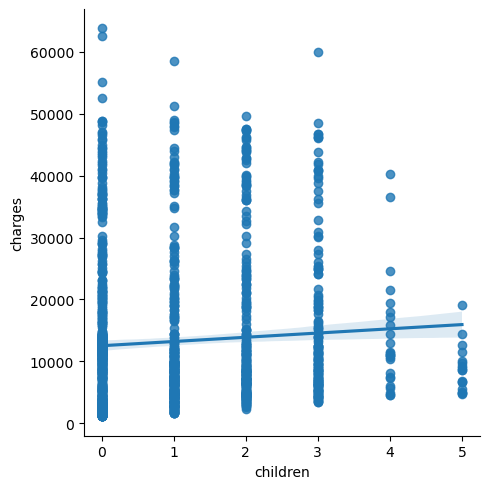

In [5]:
sns.lmplot(df, x="children", y="charges")

Как признаки влияют на целевую переменную?
Визуал признаков и значений страховых сборов

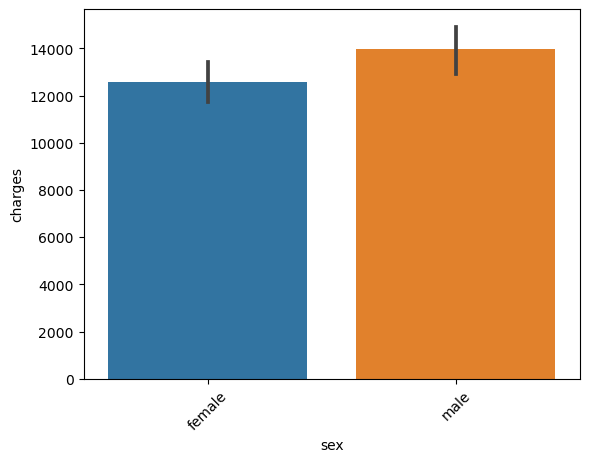

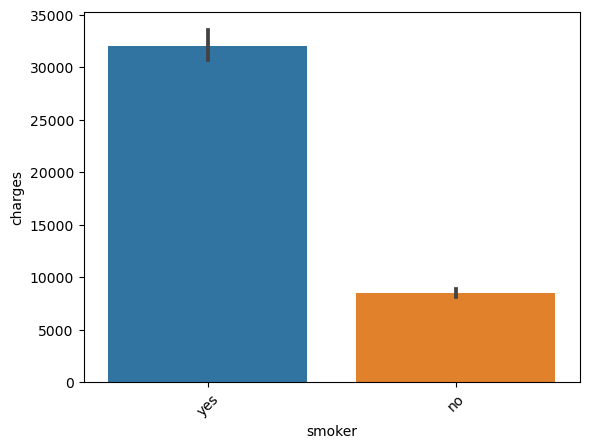

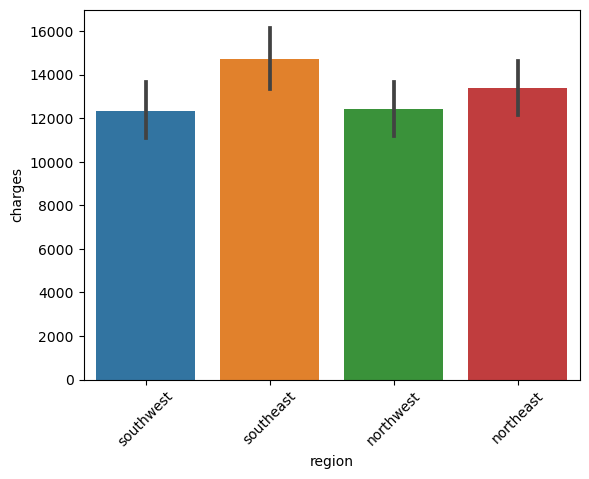

In [6]:
def cat_plotter(data, target):
    import matplotlib.pyplot as plt
    for col in data.select_dtypes(["object"]).columns:
        sns.barplot(data=data, x=col, y=target)
        plt.xticks(rotation=45)
        plt.show()
        
cat_plotter(df, "charges")

Видим что в восточных регионах выше сумма страховых взносов - можем объединить регионы по признаку восток запад
Количество детей меньше или равно 3 и больше 3 - пусть будет два варианта, тк по графику видим что взносы уменьшаются при количестве детей 4 и 5

Уменьшение количества вариантов признаков нужно чтобы фиктивные переменные не слишком расширили матрицу аргументов

In [7]:
region_dict = {
    "northwest": 1,
    "southwest": 1,
    "northeast": 0,
    "southeast": 0,
}

df["region_group"] = df["region"].map(region_dict)

df["region_group"].value_counts()

0    688
1    650
Name: region_group, dtype: int64

In [8]:
df["has_child"] = np.where(df["children"] <= 3, 0, 1)

df["has_child"].value_counts()

0    1295
1      43
Name: has_child, dtype: int64

In [9]:
df['smoker'] = np.where(df["smoker"] == 'yes', 1, 0)

In [10]:
df = df.drop(["region", "sex","children"], axis=1)
df.head()

,age,bmi,smoker,charges,region_group,has_child
0,19,27.900,1,16884.92400,1,0
1,18,33.770,0,1725.55230,0,0
2,28,33.000,0,4449.46200,0,0
3,33,22.705,0,21984.47061,1,0
4,32,28.880,0,3866.85520,1,0


Сделаем еще признаки для подгонки модели - будем добавлять или исключать их чтобы r2 приблизить к единице

In [11]:
df = df.assign(
        #age_sq = df["age"]**2,
        smoker_bmi_int = lambda x: x["smoker"] * x["bmi"]
          )
df.head()

,age,bmi,smoker,charges,region_group,has_child,smoker_bmi_int
0,19,27.900,1,16884.92400,1,0,27.9
1,18,33.770,0,1725.55230,0,0,0.0
2,28,33.000,0,4449.46200,0,0,0.0
3,33,22.705,0,21984.47061,1,0,0.0
4,32,28.880,0,3866.85520,1,0,0.0


Проверим мультиколлинеарность признаков - логично что новый признак smoker_bmi_int зависит от старого
Удаляю старый признак smoker, тк на елевую сумму больше влияет новый

In [12]:
df.corr(numeric_only = True)

,age,bmi,smoker,charges,region_group,has_child,smoker_bmi_int
age,1.000000,0.109272,-0.025019,0.299008,0.008245,-0.021092,-0.018383
bmi,0.109272,1.000000,0.003750,0.198341,-0.122011,-0.000595,0.108741
smoker,-0.025019,0.003750,1.000000,0.787251,-0.063400,-0.050466,0.974487
charges,0.299008,0.198341,0.787251,1.000000,-0.071314,-0.023179,0.845120
region_group,0.008245,-0.122011,-0.063400,-0.071314,1.000000,0.009417,-0.070453
has_child,-0.021092,-0.000595,-0.050466,-0.023179,0.009417,1.000000,-0.054715
smoker_bmi_int,-0.018383,0.108741,0.974487,0.845120,-0.070453,-0.054715,1.000000


In [13]:
df = df.drop(["smoker"], axis=1)

Разделю выборку на тест и трейн 

In [14]:
from sklearn.model_selection import train_test_split

X = sm.add_constant(df.drop(["charges"], axis=1))
y = df["charges"]


X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

X.head()

,const,age,bmi,region_group,has_child,smoker_bmi_int
1068,1.0,63,21.660,1,0,0.0
1018,1.0,54,35.815,1,0,0.0
995,1.0,39,23.275,0,0,0.0
1248,1.0,18,39.820,0,0,0.0
549,1.0,43,46.200,0,0,46.2


Запускаю кросс валидацию модели фолдами, отслеживания как меняется R2 
Удаляю фичи чтобы посмотреть как меняется качество модели

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape


kf = KFold(n_splits=5, shuffle=True, random_state=2023)

# список для записи метрик модели с конкретным фолдом
cv_lm_r2s = []
cv_lm_mae = []
cv_lm_mape = []

# для каждого фолда строится модель на признаках
for train_ind, val_ind in kf.split(X, y):
    # делю данные с конкретным фолдом на тест и трейн + валидация
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
    # обучаю модель на трейне
    model = sm.OLS(y_train, X_train).fit()
    # сохраняю метрики на валидации для текущего фолда
    cv_lm_r2s.append(r2(y_val, model.predict(X_val),))
    cv_lm_mae.append(mae(y_val, model.predict(X_val),))
    cv_lm_mape.append(mape(y_val, model.predict(X_val),))

print("Последовательно все валидации R2: ", [round(x, 3) for x in cv_lm_r2s])
print(f"Среднее значение R2 +- станд отклонение: {round(np.mean(cv_lm_r2s), 3)} +- {round(np.std(cv_lm_r2s), 3)}")

print("Последовательно все валидации MAE: ", [round(x, 3) for x in cv_lm_mae])
print(f"Среднее значение MAE +- станд отклонение: {round(np.mean(cv_lm_mae), 3)} +- {round(np.std(cv_lm_mae), 3)}")

print("Последовательно все валидации MAPE: ", [round(x, 3) for x in cv_lm_mape])
print(f"Среднее значение MAPE +- станд отклонение: {round(np.mean(cv_lm_mape), 3)} +- {round(np.std(cv_lm_mape), 3)}")


Последовательно все валидации R2:  [0.806, 0.826, 0.823, 0.85, 0.781]
Среднее значение R2 +- станд отклонение: 0.817 +- 0.023
Последовательно все валидации MAE:  [3278.485, 3076.541, 3290.026, 2844.623, 3460.636]
Среднее значение MAE +- станд отклонение: 3190.062 +- 211.299
Последовательно все валидации MAPE:  [0.305, 0.304, 0.317, 0.315, 0.298]
Среднее значение MAPE +- станд отклонение: 0.308 +- 0.007


Вижу что модель устойчивая при валидации, наилучший результат с доп фичей x["smoker"] * x["bmi"]
Запускаю на тесте и трейне, вывожу метрики на тесте - они совпали с метриками при валидации

In [16]:
model = sm.OLS(y, X).fit()

print(f"Test R2: {r2(y_test, model.predict(X_test))}")
print(f"Test MAE: {mae(y_test, model.predict(X_test))}")
print(f"Test MAPE: {mape(y_test, model.predict(X_test))}")

Test R2: 0.8216333737868065
Test MAE: 3120.2276281130985
Test MAPE: 0.2932560799079391


Какие коэффициенты посчитала модель для параметров? Видим что сильно разные от 100 до 2600

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     960.2
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:52:49   Log-Likelihood:                -10678.
No. Observations:                1070   AIC:                         2.137e+04
Df Residuals:                    1064   BIC:                         2.140e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6859.2598    928.249     -7.389      0.000   -8680.667   -5037.852
age              268.4350     11.449     23.446      0.000     245.969     290.901
bmi              142.7599     26.542      5.379      0.000      90.679     194.841
region_group     112.4925    323.522      0.348      0.728    -522.320     747.305
has_child       2582.2205    915.097      2.822      0.005     786.620    4377.821
smoker_bmi_int   807.9485     12.720     63.519      0.000     782.990     832.907
==============================================================================
Omnibus:                      482.799   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2367.356
Skew:                           2.097   Prob(JB):                         0.00
Kurtosis:                       8.959   Cond. No.                         308.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Как распределены остатки модели? Должны - нормально вокуруг нуля
Видим что этого нет.

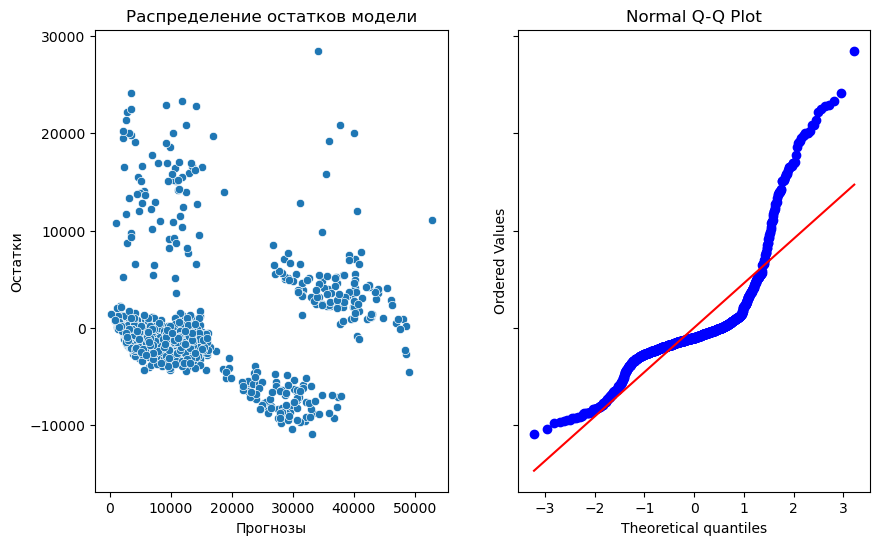

In [18]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Распределение остатков модели")
    ax[0].set_xlabel("Прогнозы")
    ax[0].set_ylabel("Остатки")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   
    
residual_analysis_plots(model)    

In [19]:
### списки для накопления информаии о качестве моделей для сравнения
models = []
r2s = []
maes = []
mapes = []

In [20]:
#записываю результаты модели
models.append('Регрессия')
r2s.append(r2(y_test, model.predict(X_test)))
maes.append(mae(y_test, model.predict(X_test)))
mapes.append(mape(y_test, model.predict(X_test)))

Возможно в данных есть выбросы, которые не дают модели сделать нормальные остатки вокург нуля?
Расстояние Кука - это мера того, насколько изменились бы остатки для всех записей, если конкретная запись не участвовала бы в вычислении коэффициентов модели. Большое расстояние Кука говорит о том, что исключение записи существенно изменяет коэффициенты, и должна рассматриваться как влияющая
Как правило, любое наблюдение с расстоянием Кука больше 1 считается наблюдением с высоким рычагом.

In [21]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).round(2)

1012    0.08
321     0.06
1300    0.03
577     0.02
1307    0.02
        ... 
496     0.00
541     0.00
552     0.00
1296    0.00
579     0.00
Name: cooks_d, Length: 1070, dtype: float64

Нет строк данных с расстоянием кука больше 1 - нет выбросов влияющих на результат.
Вариант улучшения  с целью нормализации остатков - прологарифмировать отклик 

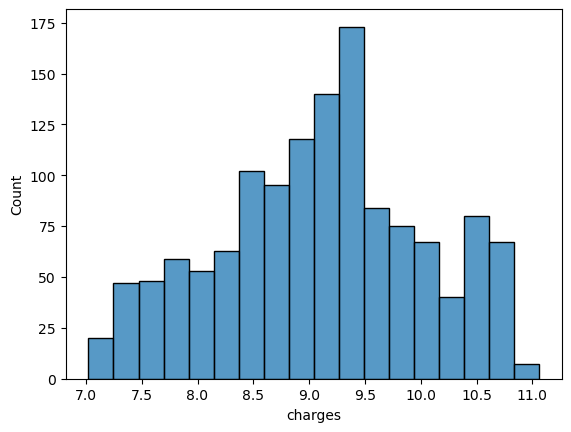

In [22]:
sns.histplot(np.log(df["charges"]));

In [23]:
X = sm.add_constant(df.drop(["charges"], axis=1))
y_log = np.log(df["charges"])


X, X_test, y, y_test = train_test_split(X, y_log, test_size=.2, random_state=2023)


model = sm.OLS(y, X).fit()

print(f"Test R2 логарифимрованный отклик возврат: {r2(np.exp(y_test), np.exp(model.predict(X_test)))}")
print(f"Test MAE логарифмированный отклик возврат: {mae(np.exp(y_test), np.exp(model.predict(X_test)))}")
print(f"Test MAPE логарифимрованный отклик: {mape(y_test, model.predict(X_test))}")
print(f"Test MAPE логарифимрованный отклик возврат: {mape(np.exp(y_test), np.exp(model.predict(X_test)))}")

Test R2 логарифимрованный отклик возврат: 0.40416288480000195
Test MAE логарифмированный отклик возврат: 4380.64133120282
Test MAPE логарифимрованный отклик: 0.032761276475620514
Test MAPE логарифимрованный отклик возврат: 0.2805486763589345


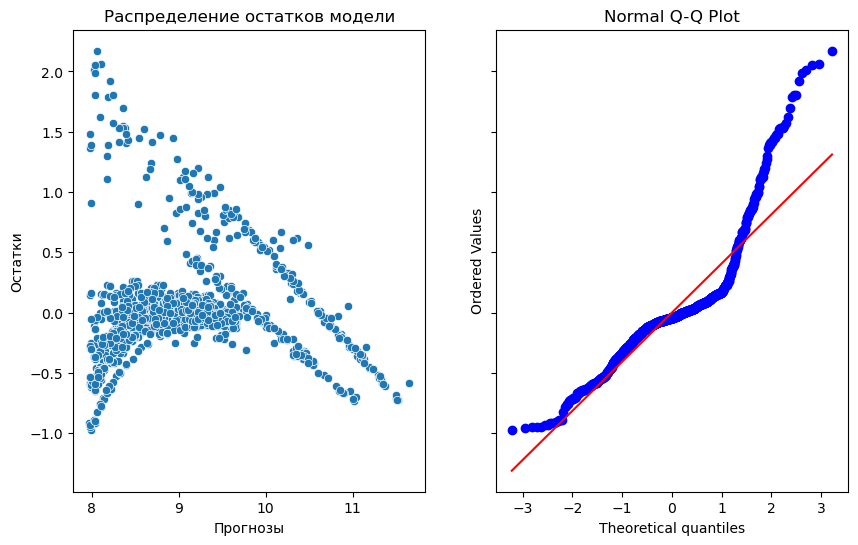

In [24]:
residual_analysis_plots(model)   

Видим что логарифирование отклика немного улучшило показатель mape, но ухудшило качество модели со стороны метрики R2

In [25]:
#записываю результаты модели логарифированного отлика с возвратом в основыне единиы измерения
models.append('РегрессияЛогарифированный отклик')
r2s.append(r2(np.exp(y_test), np.exp(model.predict(X_test))))
maes.append(mae(np.exp(y_test), np.exp(model.predict(X_test))))
mapes.append(mape(np.exp(y_test), np.exp(model.predict(X_test))))

Поработаем с расчитанными коэффициентами модели сделаем резуляризацию модели тремя способами - ридж, лассо, энет
Для этих моделей нужна стандартизаия признаков

In [26]:
from sklearn.model_selection import train_test_split

X = sm.add_constant(df.drop(["charges"], axis=1))
y = df["charges"]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=2023)

In [27]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X_train.values)
X_val = std.transform(X_valid.values)
X_te = std.transform(X_test.values)

Ридж регрессия - в целевую функцию добавляем сумму квадратов коэффициентов рассчитанных моделью для фичей, перед суммой стоит коэффициент альфа, который влияет на величину штрафа модели, его тоже можно подбирать. Сначала попробуем коэффициент альфа = 1
Коэффииенты перед фичами все еще сильно различаются. Что с качеством модели?

In [28]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1).fit(X_tr, y_train)

list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('age', 3654.9091721693617),
 ('bmi', 916.6146549252086),
 ('region_group', -4.530420467321397),
 ('has_child', 575.4221185891404),
 ('smoker_bmi_int', 10324.584612464725)]

Проверим качество модели а именно R2 для ридж регрессии с альфа = 1 на трейне

In [29]:
ridge_model.score(X_tr, y_train)

0.8172108564345077

Перебираем альфа из 200 вариантов в пределах от нуля до 1000 не включая концы

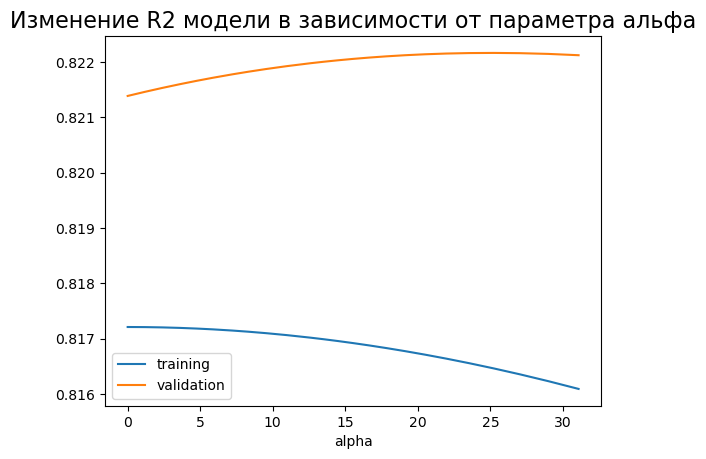

In [30]:
n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

train_scores = []
val_scores = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha).fit(X_tr, y_train)
    train_scores.append(ridge_model.score(X_tr, y_train))
    val_scores.append(ridge_model.score(X_val, y_valid))
    
scores_df = pd.DataFrame({
    "alpha": alphas,
    "training": train_scores,
    "validation": val_scores
})

scores_df[:150].set_index("alpha").plot() 
#scores_df.set_index("alpha").plot()

plt.title('Изменение R2 модели в зависимости от параметра альфа', fontsize= 16 )

plt.show();

In [31]:
scores_df.sort_values("validation", ascending=False).head()

,alpha,training,validation
146,25.235392,0.816464,0.822165
145,23.542864,0.816558,0.822162
147,27.049597,0.816356,0.822160
144,21.963854,0.816641,0.822154
148,28.994229,0.816233,0.822147


Выбираем лучший альфа, при котором R2 максимальный и с ним обучаем модель

In [32]:
std = StandardScaler()
X_m = std.fit_transform(X.values)
X_te = std.transform(X_test.values)
ridge_model = Ridge(alpha=25.235392).fit(X_m, y)

list(zip(X.columns, ridge_model.coef_))
print('R2 для оптимального альфа на  трейне', ridge_model.score(X_m, y))
print('R2 для оптимального альфа на  тесте', ridge_model.score(X_te, y_test))

R2 для оптимального альфа на  трейне 0.8181458392454237
R2 для оптимального альфа на  тесте 0.8225920804588107


Автоподбор альфа

In [33]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error as mae

n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv=5)

ridge_model.fit(X_m, y)
print('R2 на тесте  ридж модели с оптимальным альфа', ridge_model.score(X_te, y_test))
print(f"Test MAE ридж  модель с оптимальным альфа: {mae(y_test, ridge_model.predict(X_te))}")
print(f"Test MAPE ридж модели: {mape(y_test, ridge_model.predict(X_te))}")

R2 на тесте  ридж модели с оптимальным альфа 0.821796810960103
Test MAE ридж  модель с оптимальным альфа: 3127.3499685852676
Test MAPE ридж модели: 0.29523613637254387


In [34]:
#записываю результаты модели ридж
models.append('Ридж')
r2s.append(ridge_model.score(X_te, y_test))
maes.append(mae(y_test, ridge_model.predict(X_te)))
mapes.append(mape(y_test, ridge_model.predict(X_te)))

Попробуем другую модель - Лассо c автоподбором параметров  - в ней штраф это сумма модулей коэффииентов

In [35]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error as mae

n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)

lasso_model.fit(X_m, y)
print('R2 на тесте  лассо модели с оптимальным альфа', lasso_model.score(X_te, y_test))
print(f"Test MAE лассо  модель с оптимальным альфа: {mae(y_test, lasso_model.predict(X_te))}")
print(f"Test MAPE лассо модели: {mape(y_test, lasso_model.predict(X_te))}")

R2 на тесте  лассо модели с оптимальным альфа 0.8219410870379456
Test MAE лассо  модель с оптимальным альфа: 3119.5069422022934
Test MAPE лассо модели: 0.29374371151681367


In [36]:
#записываю результаты модели лассо
models.append('Лассо')
r2s.append(lasso_model.score(X_te, y_test))
maes.append(mae(y_test, lasso_model.predict(X_te)))
mapes.append(mape(y_test, lasso_model.predict(X_te)))

Эластик модель - линейная комбинация Ридж и Лассо.

In [37]:
from sklearn.linear_model import ElasticNetCV

alphas = 10 ** np.linspace(-3, 3, 200)
l1_ratios = np.linspace(.9, 1, 10) # .9, 1, 10

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)

enet_model.fit(X_m, y)
print('R2 на тесте эластик модели с оптимальным альфа', enet_model.score(X_te, y_test))
print(f"Test MAE эластик  модель с оптимальным альфа: {mae(y_test, enet_model.predict(X_te))}")
print(f"Test MAPE эластик модели: {mape(y_test, enet_model.predict(X_te))}")

R2 на тесте эластик модели с оптимальным альфа 0.8217798953696527
Test MAE эластик  модель с оптимальным альфа: 3126.5537237914373
Test MAPE эластик модели: 0.2950165671817674


In [38]:
#записываю результаты модели Энет
models.append('Энет')
r2s.append(enet_model.score(X_te, y_test))
maes.append(mae(y_test, enet_model.predict(X_te)))
mapes.append(mape(y_test, enet_model.predict(X_te)))

Сравню результаты с моделями на основе дерева решений, три модели без поиска параметров

In [39]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=6)

model.fit(X_m, y)

print('R2 на тесте  модель решающее дерево', model.score(X_te, y_test))
print(f"MAE на тесте  модель решающее дерево: {mae(y_test, model.predict(X_te))}")
print(f"MAPE на тесте  модель решающее дерево: {mape(y_test, model.predict(X_te))}")

R2 на тесте  модель решающее дерево 0.8179917190077839
MAE на тесте  модель решающее дерево: 2702.218860990921
MAPE на тесте  модель решающее дерево: 0.31028158634057307


In [40]:
#записываю результаты модели решающее дерево
models.append('РешающееДерево')
r2s.append(model.score(X_te, y_test))
maes.append(mae(y_test, model.predict(X_te)))
mapes.append(mape(y_test, model.predict(X_te)))

In [41]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(min_samples_leaf=5, n_estimators=1000, random_state=2023)

model = rf.fit(X_m, y)

print('R2 на тесте  модель случайный лес', model.score(X_te, y_test))
print(f"MAE на тесте  модель случайный лес: {mae(y_test, model.predict(X_te))}")
print(f"MAPE на тесте  модель случайный лес: {mape(y_test, model.predict(X_te))}")

R2 на тесте  модель случайный лес 0.8536628371072619
MAE на тесте  модель случайный лес: 2509.009615588048
MAPE на тесте  модель случайный лес: 0.31007712405811616


In [42]:
#записываю результаты модели решающее дерево
models.append('СлучайныйЛес')
r2s.append(model.score(X_te, y_test))
maes.append(mae(y_test, model.predict(X_te)))
mapes.append(mape(y_test, model.predict(X_te)))

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=50, random_state=2023)

model = gb.fit(X_m, y)

print('R2 на тесте  модель градиентный бустинг', model.score(X_te, y_test))
print(f"MAE на тесте  модель градиентный бустинг: {mae(y_test, model.predict(X_te))}")
print(f"MAPE на тесте  модель градиентный бустинг: {mape(y_test, model.predict(X_te))}")

R2 на тесте  модель градиентный бустинг 0.8610700816039621
MAE на тесте  модель градиентный бустинг: 2476.785847443481
MAPE на тесте  модель градиентный бустинг: 0.3139894290865404


In [44]:
#записываю результаты модели решающее дерево
models.append('ГрадиентныйБустинг')
r2s.append(model.score(X_te, y_test))
maes.append(mae(y_test, model.predict(X_te)))
mapes.append(mape(y_test, model.predict(X_te)))

Для выбора модели мне нужен составной критерий - максимальный R2 и минимальный mape

In [45]:
models_score = pd.DataFrame({
    "model": models,
    "r2s": r2s,
    "maes": maes,
    "mapes": mapes,
})
models_score.sort_values(by = ['r2s','mapes'], ascending = (False, True))

,model,r2s,maes,mapes
7,ГрадиентныйБустинг,0.861070,2476.785847,0.313989
6,СлучайныйЛес,0.853663,2509.009616,0.310077
3,Лассо,0.821941,3119.506942,0.293744
2,Ридж,0.821797,3127.349969,0.295236
4,Энет,0.821780,3126.553724,0.295017
0,Регрессия,0.821633,3120.227628,0.293256
5,РешающееДерево,0.817992,2702.218861,0.310282
1,РегрессияЛогарифированный отклик,0.404163,4380.641331,0.280549


Лучшая модель градиентный бустинг, но метрика mape высокая, обучу эти модель на логарифированном отклике и посмотрю метрику вернувшись к исходным значениям 

In [46]:
X = df.drop(["charges"], axis=1)
y = np.log(df["charges"]) #логарифирование отклика

#разделение выборки на тест и трейн
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)


std = StandardScaler() #стандартизаия фичей
X_m = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

gb = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=50, random_state=2023)#модель

model = gb.fit(X_m, y)

print('R2 на тесте  модель градиентный бустинг возврат', model.score(X_te, y_test))
print(f"MAE на тесте  модель градиентный бустинг возврат: {mae(np.exp(y_test), np.exp(model.predict(X_te)))}")
print(f"MAPE на тесте  модель градиентный бустинг возварт: {mape(np.exp(y_test), np.exp(model.predict(X_te)))}")

R2 на тесте  модель градиентный бустинг возврат 0.7886772469993859
MAE на тесте  модель градиентный бустинг возврат: 2123.346932116703
MAPE на тесте  модель градиентный бустинг возварт: 0.1927378603405531


In [47]:
#записываю результаты модели градиентный бустинг с логарифированным откликом после возврата в основыне единицы измерения
models.append('ГрадиентныйБустингЛогарифированныйОтклие')
r2s.append(model.score(X_te, y_test))
maes.append(mae(np.exp(y_test), np.exp(model.predict(X_te))))
mapes.append(mape(np.exp(y_test), np.exp(model.predict(X_te))))

In [48]:
models_score = pd.DataFrame({
    "model": models,
    "r2s": r2s,
    "maes": maes,
    "mapes": mapes,
})
models_score.sort_values(by = 'mapes')

,model,r2s,maes,mapes
8,ГрадиентныйБустингЛогарифированныйОтклие,0.788677,2123.346932,0.192738
1,РегрессияЛогарифированный отклик,0.404163,4380.641331,0.280549
0,Регрессия,0.821633,3120.227628,0.293256
3,Лассо,0.821941,3119.506942,0.293744
4,Энет,0.821780,3126.553724,0.295017
2,Ридж,0.821797,3127.349969,0.295236
6,СлучайныйЛес,0.853663,2509.009616,0.310077
5,РешающееДерево,0.817992,2702.218861,0.310282
7,ГрадиентныйБустинг,0.861070,2476.785847,0.313989


In [49]:
#функция считает ошибки прогноза в долях от факта
def mist(df, fact, pred):
    df = df.assign(delta = lambda x: abs(x[fact] - x[pred]),
                                     pct = lambda x: x.delta / x[fact] )
    return(df)

In [50]:
result =  pd.DataFrame({
          "fact": np.exp(y_test),
          "predict": np.exp(model.predict(X_te)).tolist()
                       })

result = mist(result,'fact','predict').reset_index(drop = True)
result.head()

,fact,predict,delta,pct
0,8556.90700,9503.234743,946.327743,0.110592
1,9910.35985,10668.582508,758.222658,0.076508
2,34303.16720,30346.308601,3956.858599,0.115350
3,3268.84665,5018.107251,1749.260601,0.535131
4,9855.13140,10216.976498,361.845098,0.036716


Статистика ошибок модели, метрика MAPE

In [51]:
result['pct'].describe()

count    268.000000
mean       0.192738
std        0.232211
min        0.000461
25%        0.044022
50%        0.090822
75%        0.266114
max        1.074020
Name: pct, dtype: float64

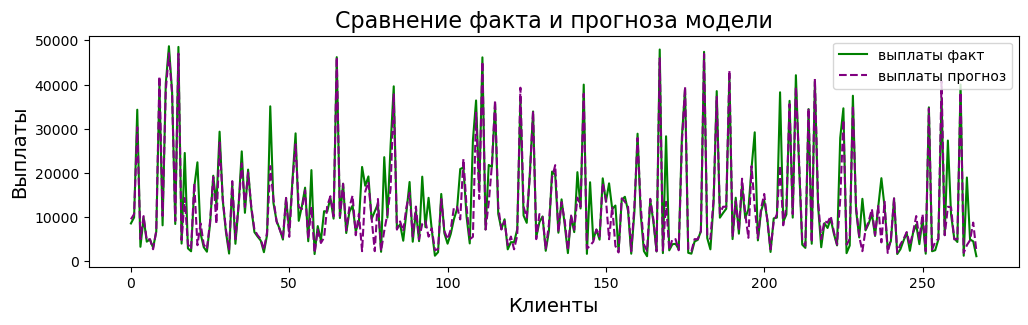

In [52]:
plt.figure(figsize=(12, 3))

plt.plot(result['fact'],  label='выплаты факт', color='green' )
plt.plot(result['predict'], label='выплаты прогноз', color='purple', linestyle='dashed')

plt.legend()

plt.ylabel('Выплаты', fontsize= 14 )
plt.xlabel('Клиенты', fontsize= 14 )
plt.title('Сравнение факта и прогноза модели', fontsize= 16 )

plt.show();